# Plots of Profiles of Dask, RADICAL-Pilot, and Spark <br> Running Blob Detector Algorithm

In [1]:
%matplotlib inline

from __future__ import division

import os

import pandas as pd
pd.options.display.width = 180

import matplotlib.pyplot as plt
from matplotlib import cm

from glob import glob
import re

from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

import numpy as np

import ast
from bokeh.palettes import viridis
from toolz import valmap, merge, memoize
import random
import itertools

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

## _Dask Data_

In [2]:
task_stream_palette = list(viridis(25))
random.shuffle(task_stream_palette)

counter = itertools.count()

_incrementing_index_cache = dict()


@memoize(cache=_incrementing_index_cache)
def incrementing_index(o):
    return next(counter)


def color_of(o, palette=task_stream_palette):
    return palette[incrementing_index(o) % len(palette)]

def color_of_message(key):
        return color_of(key)

colors = {'transfer': 'red',
          'disk-write': 'orange',
          'disk-read': 'orange',
          'deserialize': 'gray',
          'compute': color_of_message}


alphas = {'transfer': 0.4,
          'compute': 1,
          'deserialize': 0.4,
          'disk-write': 0.4,
          'disk-read': 0.4}


prefix = {'transfer': 'transfer-',
          'disk-write': 'disk-write-',
          'disk-read': 'disk-read-',
          'deserialize': 'deserialize-',
          'compute': ''}


def key_split(s):

    if type(s) is bytes:
        s = s.decode()
    if type(s) is tuple:
        s = s[0]
    try:
        words = s.split('-')
        if not words[0][0].isalpha():
            result = words[0].lstrip("'(\"")
        else:
            result = words[0]
        for word in words[1:]:
            if word.isalpha() and not (len(word) == 8 and
                                       hex_pattern.match(word) is not None):
                result += '-' + word
            else:
                break
        if len(result) == 32 and re.match(r'[a-f0-9]{32}', result):
            return 'data'
        else:
            if result[0] == '<':
                result = result.strip('<>').split()[0].split('.')[-1]
            return result
    except:
        return 'Other'



def daskprofiler(filename):

    profFile = open(filename)
    profiles = profFile.readlines()
    buffer = [ast.literal_eval(x) for x in profiles]
    workIds = {}
    id = 1

    L_start = []
    L_stop = []
    L_duration = []
    L_key = []
    L_action = []
    L_name = []
    L_color = []
    L_alpha = []
    L_y = []

    for msg in buffer:
        key = msg[0]
        name = key_split(key)
        startstops = msg[-1]
        if not workIds.has_key(msg[3]):
            workIds[msg[3]]=id
            id+=1

        for action, start, stop in startstops:
            color = colors[action]
            if type(color) is not str:
                color = color(name)

            L_start.append(start)
            L_stop.append(stop)
            L_duration.append((stop - start))
            L_key.append(key)
            L_action.append(action)
            L_name.append(name)
            L_color.append(color)
            L_alpha.append(alphas[action])
            L_y.append(workIds[msg[3]])


    return pd.DataFrame.from_dict({'start': L_start,
                                   'stop': L_stop,
                                   'duration': L_duration,
                                   'key': L_key,
                                   'name': L_name,
                                   'action':L_action,
                                   'color': L_color,
                                   'alpha': L_alpha,
                                   'y': L_y
                                  })

### Dask Constants

In [3]:
folder = 'Dask/data_blobdetector_dask'

data_range = '1[0-9]'
weak_data_configs   = [{'config' : '24tasks_24cores_%s'   % (data_range),   'nodes' : 1},
                       {'config' : '48tasks_48cores_%s'   % (data_range),   'nodes' : 2},
                       {'config' : '96tasks_96cores_%s'   % (data_range),   'nodes' : 4},
                       {'config' : '192tasks_192cores_%s' % (data_range), 'nodes' : 8}
                      ]
strong_data_configs = [{'config' : '192tasks_24cores_%s'  % (data_range),  'nodes' : 1},
                       {'config' : '192tasks_48cores_%s'  % (data_range),  'nodes' : 2},
                       {'config' : '192tasks_96cores_%s'  % (data_range),  'nodes' : 4},
                       {'config' : '192tasks_192cores_%s' % (data_range), 'nodes' : 8}
                      ]

relevant_features = ['action', 'duration', 'ttc', 'config', 'nodes', 'client_ttc']

### Wrangle Dask Data

In [4]:
raw_weakdf    = pd.DataFrame(columns=relevant_features)
raw_strongdf  = pd.DataFrame(columns=relevant_features)

for weak_config, strong_config in zip(weak_data_configs, strong_data_configs):

    weak_task_profile_files = glob(os.path.join(folder, '*' + weak_config['config'] + '.txt'))
    weak_client_profile_files = glob(os.path.join(folder, '*' + weak_config['config'] + '.csv'))
        
    # gather weak scale data
    for task_profile_file, client_profile_file in zip(weak_task_profile_files, weak_client_profile_files):

        dask_profiles = daskprofiler(task_profile_file)
        client_profiles = pd.read_csv(client_profile_file).set_index('headers')
        client_ttc = client_profiles.loc['stop_client']['times'] - client_profiles.loc['start_client']['times']
                
        compute_profiles = dask_profiles.where(dask_profiles['action'] == 'compute').dropna()
        compute_summary  = {'action'     : 'compute',
                            'duration'   : compute_profiles['duration'],
                            'ttc'        : compute_profiles['stop'].max() - compute_profiles['start'].min(),
                            'config'     : weak_config['config'],
                            'nodes'      : weak_config['nodes'],
                            'client_ttc' : client_ttc
                           }
        
        deserialize_profiles = dask_profiles.where(dask_profiles['action'] == 'deserialize').dropna()
        deserialize_summary  = {'action'     : 'deserialize',
                                'duration'   : deserialize_profiles['duration'],
                                'ttc'        : deserialize_profiles['stop'].max() - deserialize_profiles['start'].min(),
                                'config'     : weak_config['config'],
                                'nodes'      : weak_config['nodes'],
                                'client_ttc' : client_ttc
                                }
        
        raw_weakdf = raw_weakdf.append(compute_summary, ignore_index=True).reset_index(drop=True)
        raw_weakdf = raw_weakdf.append(deserialize_summary, ignore_index=True).reset_index(drop=True)
    
    strong_dask_profile_files = glob(os.path.join(folder, '*' + strong_config['config'] + '.txt'))
    strong_client_profile_files = glob(os.path.join(folder, '*' + strong_config['config'] + '.csv'))
    
    # gather strong scale data
    for task_profile_file, client_profile_file in zip(strong_dask_profile_files, strong_client_profile_files):
         
        dask_profiles = daskprofiler(task_profile_file)
        client_profiles = pd.read_csv(client_profile_file).set_index('headers')
        client_ttc = client_profiles.loc['stop_client']['times'] - client_profiles.loc['start_client']['times']
       
        compute_profiles = dask_profiles.where(dask_profiles['action'] == 'compute').dropna()
        compute_summary  = {'action'     : 'compute',
                            'duration'   : compute_profiles['duration'].mean(),
                            'ttc'        : compute_profiles['stop'].max() - compute_profiles['start'].min(),
                            'config'     : weak_config['config'],
                            'nodes'      : weak_config['nodes'],
                            'client_ttc' : client_ttc
                           }
        
        deserialize_profiles = dask_profiles.where(dask_profiles['action'] == 'deserialize').dropna()
        deserialize_summary  = {'action'     : 'deserialize',
                                'duration'   : deserialize_profiles['duration'].mean(),
                                'ttc'        : deserialize_profiles['stop'].max() - deserialize_profiles['start'].min(),
                                'config'     : weak_config['config'],
                                'nodes'      : weak_config['nodes'],
                                'client_ttc' : client_ttc
                                }
        
        raw_strongdf = raw_strongdf.append(compute_summary, ignore_index=True).reset_index(drop=True)
        raw_strongdf = raw_strongdf.append(deserialize_summary, ignore_index=True).reset_index(drop=True)

        
weak_compute_df = raw_weakdf.where(raw_weakdf['action'] == 'compute').dropna().reset_index(drop=True)

strong_compute_df = raw_strongdf.where(raw_strongdf['action'] == 'compute').dropna().reset_index(drop=True)

try:
    weak_mean    = weak_compute_df[['client_ttc', 'ttc', 'nodes', 'action']].groupby(['nodes', 'action']).mean().unstack()
    weak_error   = weak_compute_df[['client_ttc', 'ttc', 'nodes', 'action']].groupby(['nodes', 'action']).std().unstack()
except KeyError:
    pass

try:
    strong_mean  = strong_compute_df[['client_ttc', 'ttc', 'nodes', 'action']].groupby(['nodes', 'action']).mean().unstack()
    strong_error = strong_compute_df[['client_ttc', 'ttc', 'nodes', 'action']].groupby(['nodes', 'action']).std().unstack()
except KeyError:
    pass


dask_weak_mean    = weak_mean.drop(columns=[('client_ttc', 'compute')])
dask_weak_error   = weak_error.drop(columns=[('client_ttc', 'compute')])
dask_strong_mean  = strong_mean.drop(columns=[('client_ttc', 'compute')])
dask_strong_error = strong_error.drop(columns=[('client_ttc', 'compute')])

## _RP Data_

### RP Constants

In [10]:
folder      = 'Vanilla/data_blobdetector_rp'
weak_data   = 'blobdetector_rp_weak_40to44.csv'
strong_data = 'blobdetector_rp_strong_40to44.csv'

columns=['nodes', 'duration_TTC', 'duration_Units']

### Wrangle RP Data

In [11]:
raw_weakdf   = pd.read_csv(os.path.join(folder, weak_data))[columns]
raw_strongdf = pd.read_csv(os.path.join(folder, strong_data))[columns]

rp_weak_mean    = raw_weakdf.groupby('nodes').mean().drop(columns=['duration_TTC'])
rp_weak_error   = raw_weakdf.groupby('nodes').std().drop(columns=['duration_TTC'])
rp_strong_mean  = raw_strongdf.groupby('nodes').mean().drop(columns=['duration_TTC'])
rp_strong_error = raw_strongdf.groupby('nodes').std().drop(columns=['duration_TTC'])

# rp_weak_diff    = rp_weak_mean.copy()
# rp_weak_diff['duration_diff'] = rp_weak_diff['duration_TTC'] - rp_weak_diff['duration_Units']
# rp_weak_diff    = rp_weak_diff.drop(columns=['duration_TTC', 'duration_Units'])
# rp_strong_diff    = rp_strong_mean.copy()
# rp_strong_diff['duration_diff'] = rp_strong_diff['duration_TTC'] - rp_strong_diff['duration_Units']
# rp_strong_diff    = rp_strong_diff.drop(columns=['duration_TTC', 'duration_Units'])

## _Spark Data_

In [12]:
def SparkLogToDataFrame(filename):
    import json
    import pandas
    import numpy as np

    columns=['StageID','TaskId','ExecutorID','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','GettingResultTime','ResultSerializationTime','FinishTime','ResultSize']

    stat_file=open(filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((1,11),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0,0] = int(stat['Stage ID'])
            data_point[0,1] = int(stat['Task Info']['Task ID'])
            data_point[0,2] = int(stat['Task Info']['Executor ID'])
            data_point[0,3] = int(stat['Task Info']['Launch Time'])
            data_point[0,5] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[0,6] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[0,7] = int(stat['Task Info']['Finish Time'])-int(stat['Task Info']['Getting Result Time']) if int(stat['Task Info']['Getting Result Time'])!=0 else 0 
            data_point[0,8] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[0,9] = int(stat['Task Info']['Finish Time'])
            data_point[0,10] = int(stat['Task Metrics']['Result Size'])
            
            data_point[0,4]= data_point[0,9]-data_point[0,3]-data_point[0,5]-data_point[0,6]-data_point[0,8]-data_point[0,7]
            data_case = pandas.DataFrame(data_point,columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data

### Wrangle Spark Data

In [13]:
folders = glob('Spark/*/app-*')
plotting_df = pd.DataFrame(columns=['Nodes','Time_ms', 'Scaling'])
for name in folders:
    df = SparkLogToDataFrame(name)
    time = df['FinishTime'].max()-df['LaunchTime'].min()
    time /= 1000.
    node = int(re.findall('\d+', name)[0])
    name = name.replace('Spark', '')
    if 'W' in name:
        scale = 'W'
    elif 'S' in name:
        scale = 'S'
    else:
        scale = 'WS'
    plotting_df.loc[len(plotting_df)]=[node, time, scale]

In [14]:
# test_iterations = 10
test_iterations = len(plotting_df.where((plotting_df['Nodes'] == 1) & (plotting_df['Scaling'] == 'W')).dropna())
tests = len(plotting_df)
num_tests = tests / test_iterations 

times_spark = pd.DataFrame(columns=['nodes','time'])
scaling = list()
stderr = list()
for i in range(int(num_tests)):
    times_spark.loc[i] = plotting_df[i*test_iterations : (i+1)*test_iterations].mean().values
    scaling.append(plotting_df['Scaling'][i*test_iterations])
    stderr.append(plotting_df['Time_ms'][i*test_iterations : (i+1)*test_iterations].std()) 
    
times_spark['scaling'] = scaling
times_spark['stderr'] = stderr

times_spark = times_spark.sort_values(by=['nodes']).set_index(['nodes'])

spark_weak_mean    = times_spark.where((times_spark['scaling'] == 'W') | (times_spark['scaling'] == 'WS')).dropna().drop(columns=['scaling', 'stderr'])
spark_weak_error   = times_spark.where((times_spark['scaling'] == 'W') | (times_spark['scaling'] == 'WS')).dropna().drop(columns=['scaling', 'time'])
spark_strong_mean  = times_spark.where((times_spark['scaling'] == 'S') | (times_spark['scaling'] == 'WS')).dropna().drop(columns=['scaling', 'stderr'])
spark_strong_error = times_spark.where((times_spark['scaling'] == 'S') | (times_spark['scaling'] == 'WS')).dropna().drop(columns=['scaling', 'time'])

## _Plot Dask, RP, and Spark Data_

### Aggregate Dask, RP, and Spark Data

In [15]:
dask_weak_mean.columns    = ['dask_tasks_time']
dask_weak_error.columns   = ['dask_tasks_time']
dask_strong_mean.columns  = ['dask_tasks_time']
dask_strong_error.columns = ['dask_tasks_time']

rp_weak_mean.columns    = ['rp_tasks_time']
rp_weak_error.columns   = ['rp_tasks_time']
rp_strong_mean.columns  = ['rp_tasks_time']
rp_strong_error.columns = ['rp_tasks_time']

spark_weak_mean.columns    = ['spark_tasks_time']
spark_weak_error.columns   = ['spark_tasks_time']
spark_strong_mean.columns  = ['spark_tasks_time']
spark_strong_error.columns = ['spark_tasks_time']

agg_weak_mean    = pd.concat([dask_weak_mean, rp_weak_mean, spark_weak_mean], axis=1, sort=False)
agg_weak_error   = pd.concat([dask_weak_error, rp_weak_error, spark_weak_error], axis=1, sort=False)
agg_strong_mean  = pd.concat([dask_strong_mean, rp_strong_mean, spark_strong_mean], axis=1, sort=False)
agg_strong_error = pd.concat([dask_strong_error, rp_strong_error, spark_strong_error], axis=1, sort=False)

### Plot Aggregate Date

In [22]:
yticks = [1, 10, 100, 1000, 10000]
yticklabels = [str(ytick) for ytick in yticks]

xticks = [1, 2, 4, 8]
xticklabels = ['%s/%s' % (24*nodes, nodes) for nodes in xticks]

blues   = cm.get_cmap(plt.get_cmap('Blues'))
greens  = cm.get_cmap(plt.get_cmap('Greens'))
reds    = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys   = cm.get_cmap(plt.get_cmap('Greys'))

dask_color = reds(150)
rp_color = blues(150)
spark_color = greens(150)

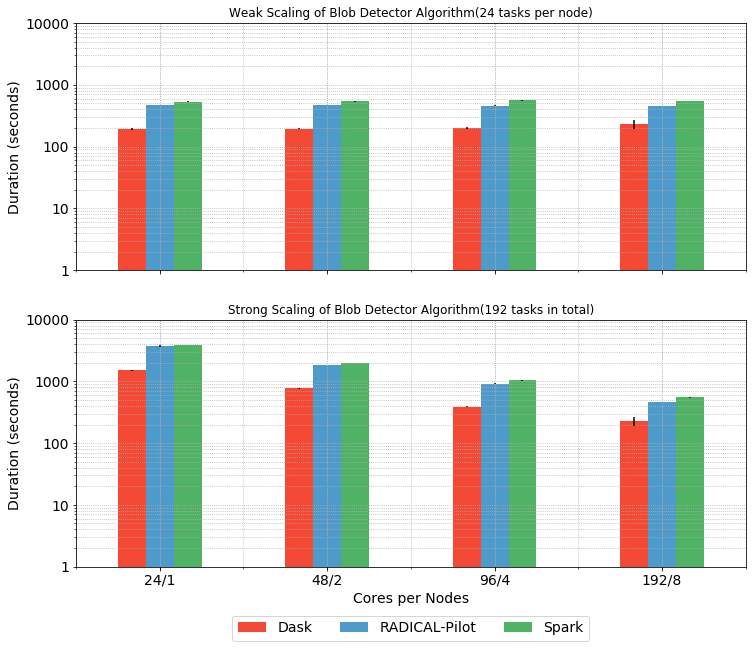

In [23]:
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
fig.set_size_inches(12,10)

weak_kwargs    = {
                 'kind'     : 'bar',
                 'log'      : True,
                 'fontsize' : 14,
                 'title'    : 'Weak Scaling of Blob Detector Algorithm(24 tasks per node)',
                 'ax'       : axes[0],
                 'yerr'     : agg_weak_error,
                 'color'    : [dask_color, rp_color, spark_color]
                  }
strong_kwargs  = {
                 'kind'     : 'bar',
                 'log'      : True,
                 'fontsize' : 14,
                 'title'    : 'Strong Scaling of Blob Detector Algorithm(192 tasks in total)',
                 'ax'       : axes[1],
                 'yerr'     : agg_strong_error,
                 'color'    : [dask_color, rp_color, spark_color]
                }

weak_scale_plot = agg_weak_mean.plot(**weak_kwargs)
weak_scale_plot.set_ylabel('Duration (seconds)', fontsize=14)
weak_scale_plot.set_ylim(bottom=min(yticks), top=max(yticks))
weak_scale_plot.set_yticks(yticks)
weak_scale_plot.set_yticklabels(yticklabels, fontsize=14)
weak_scale_plot.grid('on', which='both', linestyle=':')
axes[0].legend().set_visible(False)

strong_scale_plot = agg_strong_mean.plot(**strong_kwargs)
strong_scale_plot.set_ylabel('Duration (seconds)', fontsize=14)
strong_scale_plot.set_ylim(bottom=min(yticks), top=max(yticks))
strong_scale_plot.set_yticks(yticks)
strong_scale_plot.set_yticklabels(yticklabels, fontsize=14)
strong_scale_plot.set_xticklabels(xticklabels, rotation=0, fontsize=14)
strong_scale_plot.grid('on', which='both', linestyle=':')
strong_scale_plot.set_xlabel('Cores per Nodes', fontsize=14)
# axes[1].legend(['Dask', 'RADICAL-Pilot', 'Spark'])
axes[1].legend(['Dask', 'RADICAL-Pilot', 'Spark'],fontsize=14,bbox_to_anchor=(0., -0.3, 1., .102), loc='lower center',ncol=3, borderaxespad=0.)